# Contiguous vs non-contiguous matrix multiplication performance example

* [A difference between "**C-contiguous**" and "**F-contiguous**"](https://stackoverflow.com/questions/26998223/what-is-the-difference-between-contiguous-and-non-contiguous-arrays)

## numpy dot

In [1]:
import numba
import numpy as np

In [2]:
N = 500
a = np.random.normal(size=(N, N))
b = np.random.normal(size=(N, N))
aT = np.transpose(a)
bT = np.transpose(b)

times = {
    "matmul1":           [0, 0, 0, 0],
    "matmul2":           [0, 0, 0, 0],
    "numba_matmul":      [0, 0, 0, 0],
    "numba_matmul_inv":  [0, 0, 0, 0],
    "numba_matmul_cuda": [0, 0, 0, 0],
}

In [3]:
@numba.njit()
def matmul1(m1, m2):
    return m1 @ m2

In [4]:
def p_contig(name, m):
    print(f"{name}\t{m.data.c_contiguous}\t\t{m.data.f_contiguous}")

In [5]:
print("Matrix\tC-contiguous\tF-contiguous")
print("------\t------------\t------------")
p_contig("a", a)
p_contig("a^T", aT)
p_contig("b", b)
p_contig("b^T", bT)

Matrix	C-contiguous	F-contiguous
------	------------	------------
a	True		False
a^T	False		True
b	True		False
b^T	False		True


In [6]:
times["matmul1"][0] = %timeit -o matmul1(a, b)

45.1 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
times["matmul1"][1] = %timeit -o matmul1(aT, b)

66.9 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
times["matmul1"][2] = %timeit -o matmul1(a, bT)

89.1 ms ± 861 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
times["matmul1"][3] = %timeit -o matmul1(aT, bT)

89.5 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# We can improve our result and check if both matrices are f-contiguous inside our matmul function
def matmul2(m1, m2):
    if m1.data.f_contiguous and m2.data.f_contiguous:
        return np.transpose(matmul1(np.transpose(m1), np.transpose(m2)))
    return matmul1(m1, m2)

In [11]:
times["matmul2"][0] = %timeit -o matmul2(a, b)

45.6 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
times["matmul2"][1] = %timeit -o matmul2(aT, b)

63.7 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
times["matmul2"][2] = %timeit -o matmul2(a, bT)

88.2 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
times["matmul2"][3] = %timeit -o matmul2(a, b)

46 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Manual implementation

In [15]:
# From the first seminar
@numba.njit
def numba_matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
    return c

In [16]:
times["numba_matmul"][0] = %timeit -o -r 7 -n 10 numba_matmul(a, b)

133 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
times["numba_matmul"][1] = %timeit -o -r 7 -n 10 numba_matmul(aT, b)

158 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
times["numba_matmul"][2] = %timeit -o -r 7 -n 10 numba_matmul(a, bT)

99.5 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
times["numba_matmul"][3] = %timeit -o -r 7 -n 10 numba_matmul(aT, bT)

127 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# Same function, but the loops are ordered differently
@numba.njit
def numba_matmul_inv(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = np.zeros((n, m))
    for j in range(m):
        for i in range(n):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
    return c

In [21]:
times["numba_matmul_inv"][0] = %timeit -o -r 7 -n 10 numba_matmul_inv(a, b)

128 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
times["numba_matmul_inv"][1] = %timeit -o -r 7 -n 10 numba_matmul_inv(aT, b)

163 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
times["numba_matmul_inv"][2] = %timeit -o -r 7 -n 10 numba_matmul_inv(a, bT)

102 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
times["numba_matmul_inv"][3] = %timeit -o -r 7 -n 10 numba_matmul_inv(aT, bT)

129 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## CUDA

In [25]:
# From the first seminar
import torch
from numba import cuda
@cuda.jit
def numba_matmul_kernel(a, b, c, m, k):
    thread_id = cuda.threadIdx.x
    block_id = cuda.blockIdx.x # same as n

    step = cuda.blockDim.x

    for i in range(thread_id, m, step):
        for s in range(k):
            c[block_id, i] += a[block_id, s] * b[s, i]

def numba_matmul_cuda(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = torch.zeros((n, m)).cuda()

    grid_size = n
    block_size = 32 * (max(1, m // 32)) # Block size should be a multiple of 32

    numba_matmul_kernel[grid_size, block_size](a, b, c, m, k)
    return c

In [26]:
a_c  = torch.Tensor(a).cuda()
b_c  = torch.Tensor(b).cuda()
aT_c = torch.Tensor(aT).cuda()
bT_c = torch.Tensor(bT).cuda()

In [27]:
times["numba_matmul_cuda"][0] = %timeit -o numba_matmul_cuda(a_c, b_c)

19.9 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
times["numba_matmul_cuda"][1] = %timeit -o numba_matmul_cuda(aT_c, b_c)

24 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
times["numba_matmul_cuda"][2] = %timeit -o numba_matmul_cuda(a_c, bT_c)

38.1 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
times["numba_matmul_cuda"][3] = %timeit -o numba_matmul_cuda(aT_c, bT_c)

38.1 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Summary

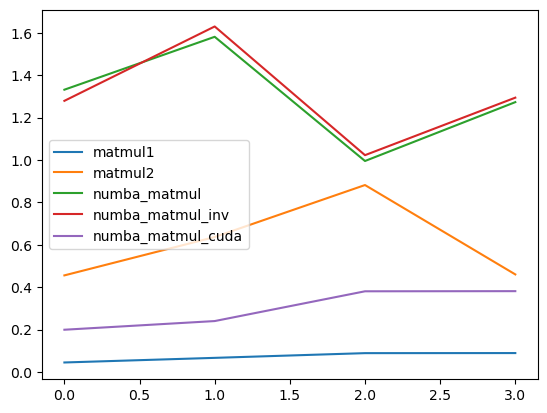

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for test in times:
    plt.plot(list(map(lambda x: sum(x.all_runs) / len(x.all_runs), times[test])), label=test)
    
ax.legend()